In [35]:
import torch

import tr_util
import util
from Dimploma.ppo_parallel_custom import Agent
from Dimploma.utils.graph_provider import GraphProvider
from Dimploma.utils.my_agent_base import RandomAgent, OptimalAgent
from Dimploma.utils.testingResult import TestResult
from Dimploma.zNetwork.model_global import HybridNetworkGlobal
from my_gcn import GCN

In [2]:
%load_ext autoreload
%autoreload 2

In [91]:
# default_path = 'results/min_tree_ppo/node/'
default_path = 'results/min_tree_ppo/node_cuda/'
agent_path = '250307_14#n10_e33_g20_without'
agent_print_name = 'Bez indexov'
# agent_print_name = 'Náš agent'
testing_path = f'{default_path}{agent_path}'

compare = True
# compare_default_path = 'results/min_tree_ppo/node/'
compare_default_path = 'results/min_tree_ppo/node_cuda/'
compare_agent_path = '250307_14#n10_e33_g20_with'
compare_print_name = 'S indexami'
# compare_print_name = 'Porovnávací agent'
compare_testing_path = f'{compare_default_path}{compare_agent_path}'

tr_util.load_desc(testing_path)
print('----------------------------------------')
tr_util.load_desc(compare_testing_path)


Training comment:
Experiments comparing removing of indexes from nodes
testing graph 20 without indexes

Trying out training with:

Training
Iterations: 1000
Epochs: 10
Batch size: 64
Steps amount: 18
On device: cuda
with early stopping


Network:
3-1 GAT layers
2 linear layers
with catenation between layers

Graphs:
Loaded graph from graphs/graph20_n10_e33_index.pt
Node amount: 10
Edge amount: 33
Node features: 1
Without indexes in nodes


Parameters:
Gamma: 0.99
Epsilon: 0.3
Coef_value: 0.5
Coef_Entropy: 0.001
Gae_lambda: 0.95
Learning rate: 0.00025

----------------------------------------

Training comment:
Experiments comparing removing of indexes from nodes
testing graph 20 with indexes

Trying out training with:

Training
Iterations: 1000
Epochs: 10
Batch size: 64
Steps amount: 18
On device: cuda
with early stopping


Network:
3-1 GAT layers
2 linear layers
with catenation between layers

Graphs:
Fixed graph saved  as graphs/graph20_n10_e33_index.pt
Node amount: 10
Edge amount:

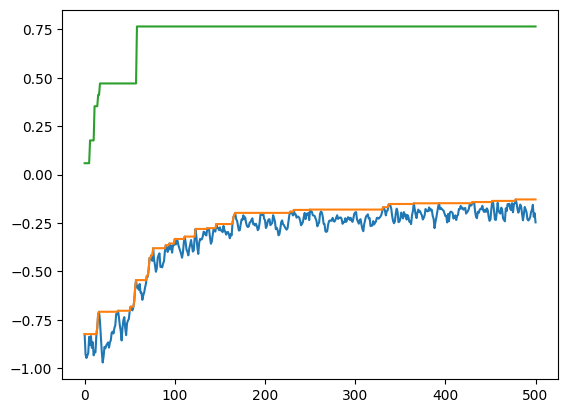

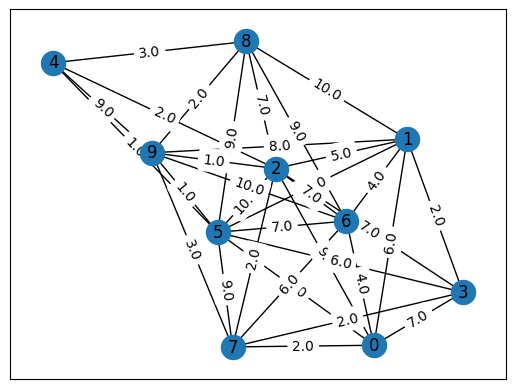

Loading model from results/min_tree_ppo/node_cuda/250307_14#n10_e33_g20_with/models/iter_999_last.pt


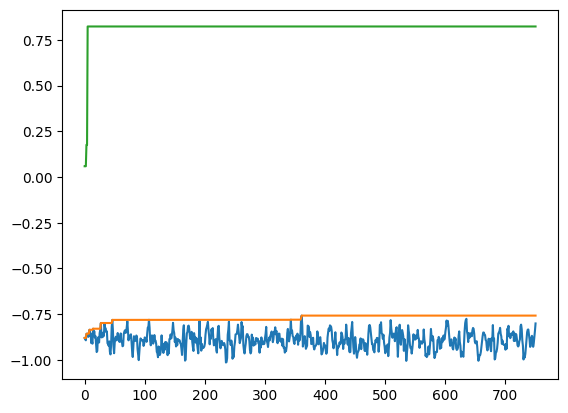

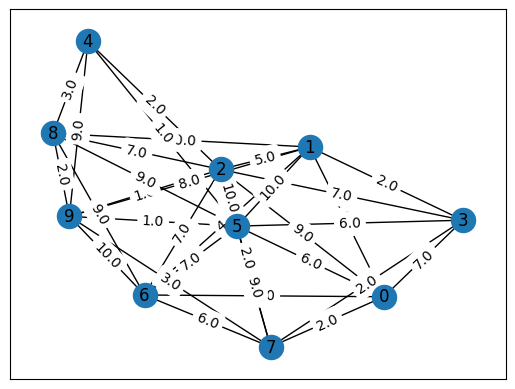

Loading model from results/min_tree_ppo/node_cuda/250307_14#n10_e33_g20_without/models/iter_999_last.pt


In [92]:
node_amount = 10
max_edge_amount = torch.sum(torch.arange(node_amount)).item()
edge_amount = 33

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
iteration_amount = 1000

# Main agent
main_hybrid = False
node_features = 2  # (index, {0,1} selected or not)
position = False
remove_index = True
if position:
    node_features += 2
if remove_index:
    node_features -= 1

if main_hybrid:
    main_gcn = HybridNetworkGlobal(node_features, node_amount)
    random_gcn = HybridNetworkGlobal(node_features, node_amount)
else:
    main_gcn = GCN(node_amount, node_features, cat=True, conv_layers=3, conv_p_layers=1, linear_layers=2, remove_index=remove_index)
    random_gcn = GCN(node_amount, node_features, cat=True, conv_layers=3, conv_p_layers=1, linear_layers=2, remove_index=remove_index)



graph_provider = GraphProvider(fixed_graph=None, device=device, nodes=node_amount, edges=edge_amount, position=position)


# Comparing agent
if compare:
    compare_hybrid = False
    compare_node_features = 2  # (index, {0,1} selected or not)
    compare_position = False
    compare_remove_index = False
    if compare_position:
        compare_node_features += 2
    if compare_remove_index:
        compare_node_features -= 1

    if compare_hybrid:
        compare_gcn = HybridNetworkGlobal(compare_node_features, node_amount)
    else:
        compare_gcn = GCN(node_amount, compare_node_features, cat=True, conv_layers=3, conv_p_layers=1, linear_layers=2, remove_index=compare_remove_index)
    _, _, compare_agent_test = tr_util.load_agent_for_testing(compare_testing_path, iteration_amount, graph_provider, compare_gcn, device)



loaded_graph, test_env, agent_test = tr_util.load_agent_for_testing(testing_path, iteration_amount, graph_provider, main_gcn, device)

In [93]:
test_amount = 100
pretty_print = True
print_rews = False

tests = TestResult(node_amount, test_amount)

#random agents
random_uniform = RandomAgent()

random_net = Agent(model=random_gcn, device=device, name="random_test", override=True, test=True)

tests.addAgent(agent_print_name, agent_test, 'orange')
if compare:
    # noinspection PyUnboundLocalVariable
    tests.addAgent(compare_print_name, compare_agent_test, 'yellow')
tests.addAgent('Optimum' if pretty_print else 'Optimal', OptimalAgent(), 'green')
tests.addAgent('Náhodný výber' if pretty_print else 'Random uniform', random_uniform, 'red')
tests.addAgent('Náhodná sieť' if pretty_print else 'Random network', random_net)


Bez indexov
Priemer: 49.68, Min: 32.00, Max: 73.00
S indexami
Priemer: 36.92, Min: 28.00, Max: 50.00
Optimum
Priemer: 17.00, Min: 17.00, Max: 17.00
Náhodný výber
Priemer: 47.70, Min: 24.00, Max: 64.00
Náhodná sieť
Priemer: 49.78, Min: 31.00, Max: 69.00


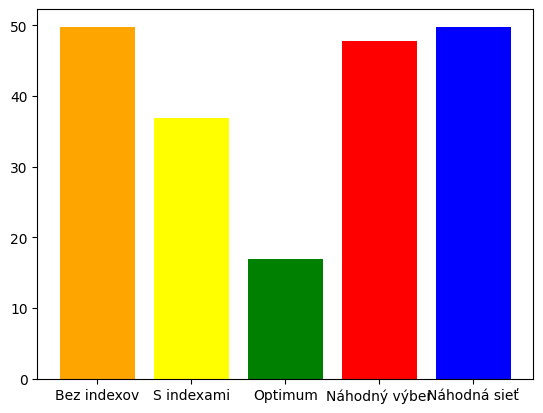

In [94]:
tests.test(test_env)
if pretty_print:
    tests.print_result_pretty()
else:
    tests.print_result(print_rews)
# print(f'Optimal: {test_env.calculate_min_span_tree()}')

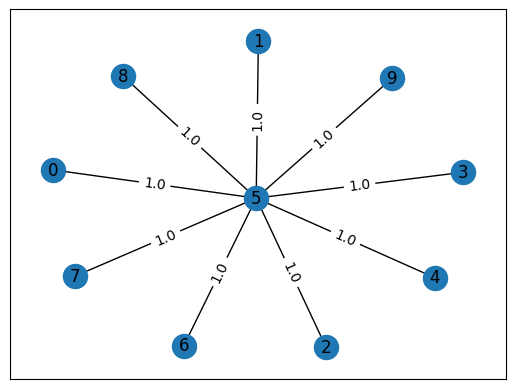

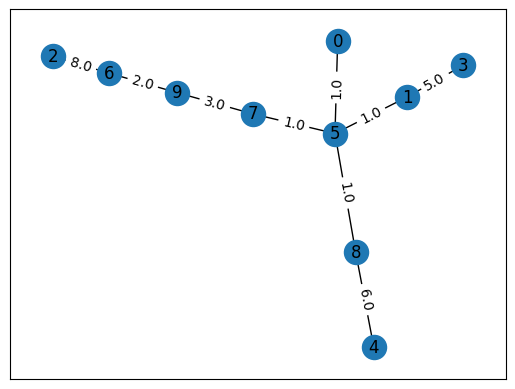

(tensor([1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1.]),
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1.1111111111111112],
 [7, 9, 1, 5, 5, 7, 3, 1, 2, 6, 0, 5, 8, 5, 9, 6, 8, 4])

In [102]:
_, a, b, c = agent_test.test(test_env)
util.show_data(test_env.min_tree)
test_env.show_selected_tree()

# mask = torch.argwhere(graph_test.edge_attr[:, 1] == 1)[:, 0]
# sel_graph = Data(x=graph_test.x, edge_index=graph_test.edge_index[:, mask], edge_weight=graph_test.edge_weight[mask])
# sel_graph_g = util.my_to_networkx(sel_graph)
# util.show_data(sel_graph)
a,b,c

In [103]:
torch.cat([util.get_node_sums(loaded_graph).T, util.get_out_edges(loaded_graph).T], dim=1).T

tensor([[5.0000, 8.0000, 7.0000, 9.0000, 0.0000, 1.0000, 3.0000, 2.0000, 4.0000,
         6.0000],
        [0.9000, 2.0000, 2.5000, 2.6000, 2.6000, 3.2000, 3.2000, 3.5000, 3.6000,
         3.7000],
        [0.0000, 1.0000, 2.0000, 7.0000, 8.0000, 9.0000, 3.0000, 4.0000, 6.0000,
         5.0000],
        [6.0000, 6.0000, 6.0000, 6.0000, 6.0000, 6.0000, 7.0000, 7.0000, 7.0000,
         9.0000]])

In [ ]:
torch.cat([loaded_graph.edge_index.T, loaded_graph.edge_attr], dim=1)